<a href="https://colab.research.google.com/github/amaillis94/project2_nyc_classification/blob/main/NYC_analysis_amaillis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from dotenv import load_dotenv
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from pandas.plotting import scatter_matrix

Overwriting /content/.env


In [3]:
load_dotenv("/content/.env")
# Confirming .env
print("User:", os.getenv("DB_USER"))

User: avnadmin


In [4]:
#Connect to Aiven to source data
from sqlalchemy import create_engine


engine = create_engine(
    f"postgresql+psycopg2://{os.getenv('DB_USER')}:{os.getenv('DB_PASS')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}?sslmode=require",
    connect_args={
        "sslmode": "require",
        "sslrootcert": "/content/ca.pem"
    }
)


In [5]:
nyc_data=pd.read_sql("SELECT * FROM df;", engine)
nyc_data.head(5)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,32310363,12/31/2015 11:59:45 PM,01-01-16 0:55,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10034.0,71 VERMILYEA AVENUE,...,None,None,None,None,None,None,None,40.865682,-73.923501,"(40.86568153633767, -73.92350095571744)"
1,32309934,12/31/2015 11:59:44 PM,01-01-16 1:26,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,11105.0,27-07 23 AVENUE,...,None,None,None,None,None,None,None,40.775945,-73.915094,"(40.775945312321085, -73.91509393898605)"
2,32309159,12/31/2015 11:59:29 PM,01-01-16 4:51,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,10458.0,2897 VALENTINE AVENUE,...,None,None,None,None,None,None,None,40.870325,-73.888525,"(40.870324522111424, -73.88852464418646)"
3,32305098,12/31/2015 11:57:46 PM,01-01-16 7:43,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,10461.0,2940 BAISLEY AVENUE,...,None,None,None,None,None,None,None,40.835994,-73.828379,"(40.83599404683083, -73.82837939584206)"
4,32306529,12/31/2015 11:56:58 PM,01-01-16 3:24,NYPD,New York City Police Department,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,11373.0,87-14 57 ROAD,...,None,None,None,None,None,None,None,40.733060,-73.874170,"(40.733059618956815, -73.87416975810375)"


In [6]:
nyc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300698 entries, 0 to 300697
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unique Key                      300698 non-null  int64  
 1   Created Date                    300698 non-null  object 
 2   Closed Date                     298534 non-null  object 
 3   Agency                          300698 non-null  object 
 4   Agency Name                     300698 non-null  object 
 5   Complaint Type                  300698 non-null  object 
 6   Descriptor                      294784 non-null  object 
 7   Location Type                   300567 non-null  object 
 8   Incident Zip                    298083 non-null  float64
 9   Incident Address                256288 non-null  object 
 10  Street Name                     256288 non-null  object 
 11  Cross Street 1                  251419 non-null  object 
 12  Cross Street 2  

In [7]:
#drop columns that are either entirely or mostly (>90%) missing
nyc_data.dropna(axis=1, thresh=(len(nyc_data)*.1), inplace=True)
nyc_data.shape

(300698, 41)

In [8]:
#Make all datetimes, datetime format
nyc_data['Created Date'] = pd.to_datetime(nyc_data['Created Date'])
nyc_data['Closed Date'] = pd.to_datetime(nyc_data['Closed Date'])
nyc_data['Due Date'] = pd.to_datetime(nyc_data['Due Date'])

/tmp/ipython-input-181489170.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nyc_data['Created Date'] = pd.to_datetime(nyc_data['Created Date'])
/tmp/ipython-input-181489170.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nyc_data['Closed Date'] = pd.to_datetime(nyc_data['Closed Date'])
/tmp/ipython-input-181489170.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nyc_data['Due Date'] = pd.to_datetime(nyc_data['Due Date'])


In [9]:
top_n = 5
top_complaints = nyc_data['Complaint Type'].value_counts().nlargest(top_n)
print(f"\nTop {top_n} Complaint types:")
print(top_complaints)


Top 5 Complaint types:
Complaint Type
Blocked Driveway           77044
Illegal Parking            75361
Noise - Street/Sidewalk    48612
Noise - Commercial         35577
Derelict Vehicle           17718
Name: count, dtype: int64


In [10]:
nyc_data['hrs_to_completion'] = (nyc_data['Closed Date'] - nyc_data['Created Date']).dt.total_seconds() / 3600
nyc_data['hrs_to_completion'].describe()

,hrs_to_completion
count,298534.000000
mean,4.314398
std,6.089484
min,0.016667
25%,1.275833
50%,2.715417
75%,5.350000
max,592.872778


<Axes: >

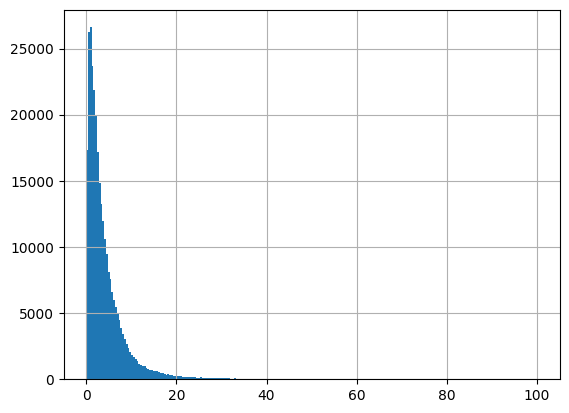

In [11]:
#Plot distribution of SR hrs to completion
#Max hrs_to_completion=592.8 omitted from figure to more easily visualize distr. of variable

nyc_data['hrs_to_completion'].hist(bins=250,range=[0,100])

In [12]:
nyc_data['month']=nyc_data['Created Date'].dt.month
nyc_data['year']=nyc_data['Created Date'].dt.year

In [13]:
grouped_counts = nyc_data.groupby(['month','year','Borough']).size()
print(grouped_counts)

month  year  Borough      
3      2015  BRONX              297
             BROOKLYN           832
             MANHATTAN          499
             QUEENS             720
             STATEN ISLAND      105
             Unspecified         18
4      2015  BRONX             3212
             BROOKLYN          8771
             MANHATTAN         6621
             QUEENS            7453
             STATEN ISLAND     1050
             Unspecified        198
5      2015  BRONX             5126
             BROOKLYN         11623
             MANHATTAN         8851
             QUEENS            9156
             STATEN ISLAND     1263
             Unspecified        418
6      2015  BRONX             4848
             BROOKLYN         11887
             MANHATTAN         7497
             QUEENS            9464
             STATEN ISLAND     1385
             Unspecified        234
7      2015  BRONX             5556
             BROOKLYN         10693
             MANHATTAN         7568
 

In [14]:
#remove unspecified rows? Or map them to a Borough using lat/long?
#Update: remove. Lat/Long missing for borough='unspecified'
filtered_df=nyc_data[nyc_data['Borough']=='Unspecified']
filtered_df.shape
print(filtered_df.info())

nyc_data = nyc_data[nyc_data.Borough != 'Unspecified']


<class 'pandas.core.frame.DataFrame'>
Index: 2574 entries, 34 to 300693
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Unique Key                      2574 non-null   int64         
 1   Created Date                    2574 non-null   datetime64[ns]
 2   Closed Date                     466 non-null    datetime64[ns]
 3   Agency                          2574 non-null   object        
 4   Agency Name                     2574 non-null   object        
 5   Complaint Type                  2574 non-null   object        
 6   Descriptor                      2567 non-null   object        
 7   Location Type                   2565 non-null   object        
 8   Incident Zip                    0 non-null      float64       
 9   Incident Address                2565 non-null   object        
 10  Street Name                     2565 non-null   object        
 11  Cross 

In [15]:
#Daily average number of service requests by borough
index = nyc_data.set_index('Created Date')

daily_counts = index.groupby('Borough').resample('D').size().unstack(fill_value=0)
average_daily_count = daily_counts.mean(axis=1)

print("\nAverage daily number of service requests per Borough:")
print(average_daily_count)


Average daily number of service requests per Borough:
Borough
BRONX            146.410072
BROOKLYN         353.622302
MANHATTAN        237.881295
QUEENS           290.075540
STATEN ISLAND     44.399281
dtype: float64


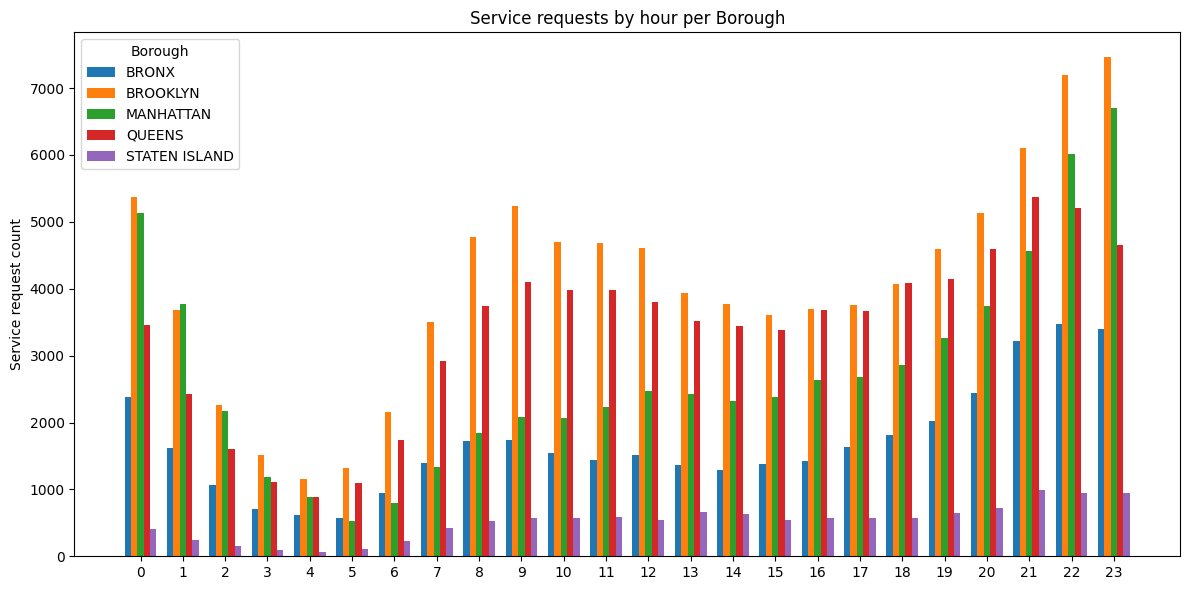

In [16]:
#Create figure to check counts of complaint by Borough
nyc_data['hour'] = nyc_data['Created Date'].dt.hour
hr_counts = nyc_data.groupby(['Borough', 'hour']).size().reset_index(name='hr_count')

# Pivot to get borough as columns
pivot_df = hr_counts.pivot(index='hour', columns='Borough', values='hr_count').fillna(0)

# Set up bar positions
x = np.arange(len(pivot_df.index))
width = 0.15
fig, ax = plt.subplots(figsize=(12,6))


for i, borough in enumerate(pivot_df.columns):
    ax.bar(x + i*width, pivot_df[borough], width, label=borough)

# Plot
ax.set_ylabel('Service request count')
ax.set_title('Service requests by hour per Borough')
ax.set_xticks(x + width * (len(pivot_df.columns)-1) / 2, pivot_df.index)
ax.legend(title="Borough")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [17]:
# Creating boolean weekend variable
nyc_data['day_int'] = nyc_data['Created Date'].dt.dayofweek
nyc_data['is_weekend'] = nyc_data['day_int'] > 4

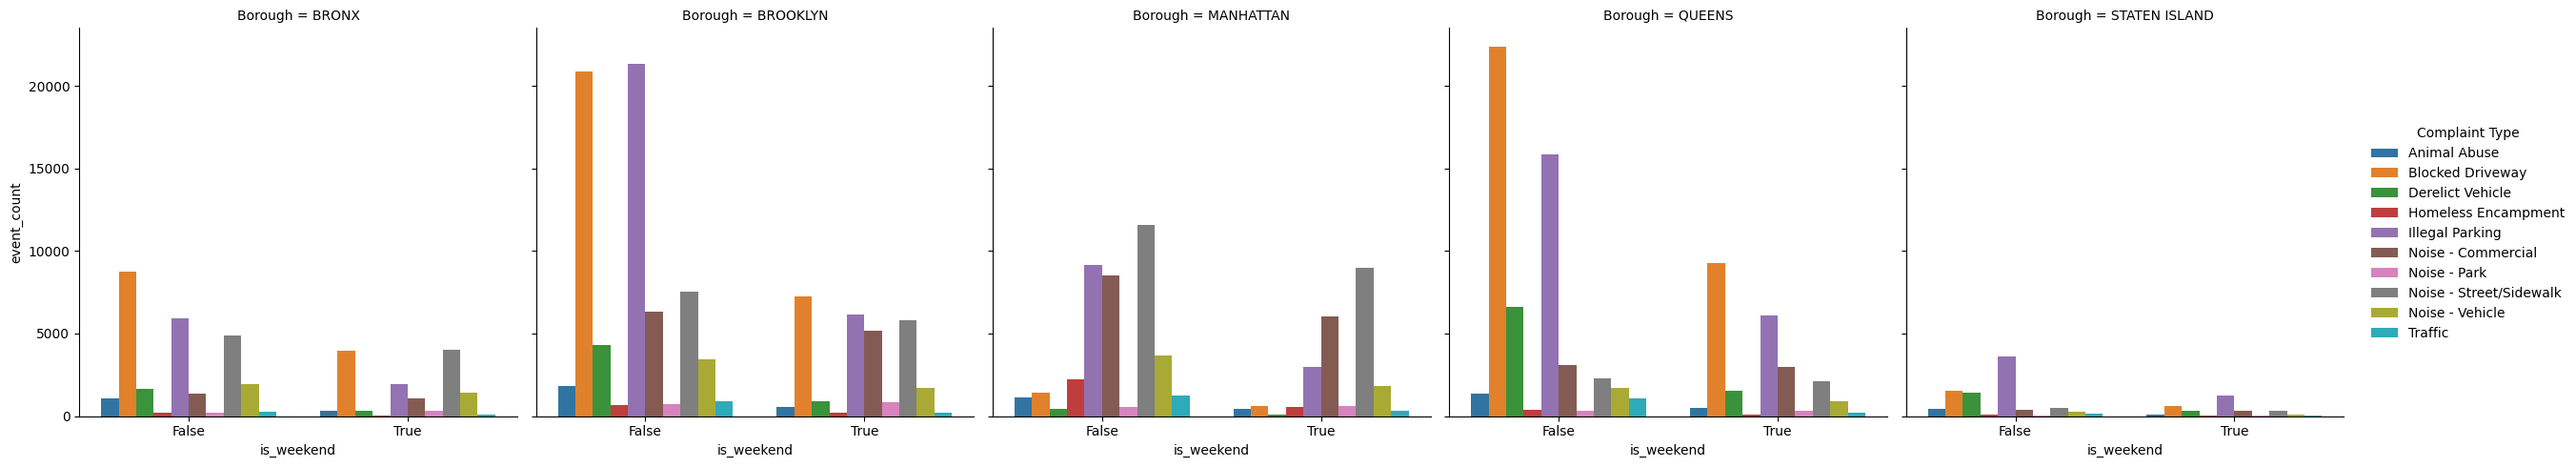

In [18]:
#Set up data limited to only top 10 complaints
top_complaints = nyc_data['Complaint Type'].value_counts().nlargest(10).index
top10 = nyc_data[nyc_data['Complaint Type'].isin(top_complaints)]

exploratory = (top10.groupby(["is_weekend", "Borough", "Complaint Type"]).size().reset_index(name="event_count"))

#Visualize top 10 complaints by Borough and weekend vs. weekday
sea.catplot(
    data=exploratory,
    x="is_weekend",
    y="event_count",
    hue="Complaint Type",
    col="Borough",
    kind="bar",
    errorbar=None
)
plt.show()

In [19]:
descriptive_stats = top10.groupby('Complaint Type')['hrs_to_completion'].describe()
print("Descriptive statistics for Hourly completion time grouped by Complaint Type:")
print(descriptive_stats)

Descriptive statistics for Hourly completion time grouped by Complaint Type:
                           count      mean        std       min       25%  \
Complaint Type                                                              
Animal Abuse              7767.0  5.213476   8.621761  0.064722  1.644861   
Blocked Driveway         76753.0  4.738139   5.570640  0.047500  1.600000   
Derelict Vehicle         17542.0  7.346087  11.064877  0.050000  1.710625   
Homeless Encampment       4416.0  4.365570   5.394946  0.083333  1.362778   
Illegal Parking          74314.0  4.485967   5.953886  0.043611  1.383333   
Noise - Commercial       35196.0  3.136565   4.072504  0.016667  0.944167   
Noise - Park              4015.0  3.401711   4.003295  0.071389  0.947500   
Noise - Street/Sidewalk  48009.0  3.438261   5.442721  0.033333  1.000000   
Noise - Vehicle          17027.0  3.588587   4.602675  0.045278  1.100000   
Traffic                   4496.0  3.448681   4.740070  0.077778  0.780625   

In [20]:
descriptive_stats1 = top10['hrs_to_completion'].describe()
print("Descriptive statistics for overall Hourly completion time:")
print(descriptive_stats1)

Descriptive statistics for overall Hourly completion time:
count    289535.000000
mean          4.322106
std           6.075204
min           0.016667
25%           1.283333
50%           2.717500
75%           5.354167
max         592.872778
Name: hrs_to_completion, dtype: float64


In [21]:
#Outcome variable (>5 hrs to completion Y/N)
nyc_data['y1'] = nyc_data['hrs_to_completion'].apply(lambda x: 1 if x > 3.999 else 0)

In [22]:
#recode complaint type and hour to reduce dimensions
nyc_data['complaints_cat']=nyc_data['Complaint Type'].where(nyc_data['Complaint Type'].isin(top_complaints),
                                    other='other')

def assign_month_cat(month):
    if 3 <= month < 6:
        return 'Spring'
    elif 6 <= month < 10:
        return 'Summer'
    elif 10 <= month < 1:
        return 'Fall'
    else:
        return 'Winter'

nyc_data['month_cat'] = nyc_data['month'].apply(assign_month_cat)

In [23]:
#Creating feature to indicate "urgent request" which will be requests closed within the 25th percentile, or 1.3 hrs
nyc_data = nyc_data.sort_values(by=['complaints_cat', 'Created Date'])

nyc_data['prior_median'] = (nyc_data.groupby('complaints_cat')['hrs_to_completion'].transform(lambda x: x.shift().expanding().median()))

nyc_data['urgent'] = np.where(nyc_data['prior_median'] < 1.3, 1, 0)

In [24]:
#limit data to characteristics used in model and check for missing
model=nyc_data[['Borough','complaints_cat','is_weekend','y1','hour','month_cat']]
model=model.dropna()

total_missing = model.isnull().sum().sum()
print(f"Total missing values in the DataFrame: {total_missing}")

Total missing values in the DataFrame: 0


In [40]:
## A/B Testing (compare mean completion times by Borough)
from scipy import stats


# Splitting groups
bronx = nyc_data[nyc_data['Borough'] == 'BRONX']['hrs_to_completion'].dropna()
brooklyn = nyc_data[nyc_data['Borough'] == 'BROOKLYN']['hrs_to_completion'].dropna()
manhattan = nyc_data[nyc_data['Borough'] == 'MANHATTAN']['hrs_to_completion'].dropna()
queens = nyc_data[nyc_data['Borough'] == 'QUEENS']['hrs_to_completion'].dropna()
staten_isl = nyc_data[nyc_data['Borough'] == 'STATEN ISLAND']['hrs_to_completion'].dropna()

# --- SAMPLING ---
# Will use 5,000 total
sample_size = min(1000, len(bronx), len(brooklyn), len(manhattan), len(queens), len(staten_isl))

# Randomly sample without replacement
bronx_sample = bronx.sample(sample_size, random_state=42)
brooklyn_sample = brooklyn.sample(sample_size, random_state=42)
manhattan_sample = manhattan.sample(sample_size, random_state=42)
queens_sample = queens.sample(sample_size, random_state=42)
staten_isl_sample = staten_isl.sample(sample_size, random_state=42)

# Summary stats
print("Bronx - mean:", bronx_sample.mean(), "median:", bronx_sample.median())
print("Brooklyn - mean:", brooklyn_sample.mean(), "median:", brooklyn_sample.median())
print("Manhattan - mean:", manhattan_sample.mean(), "median:", manhattan_sample.median())
print("Queens - mean:", queens_sample.mean(), "median:", queens_sample.median())
print("Staten Island - mean:", staten_isl_sample.mean(), "median:", staten_isl_sample.median())

# Check normality (Shapiro-Wilk test on sampled data)
_, p_bronx = stats.shapiro(bronx_sample)
_, p_brooklyn = stats.shapiro(brooklyn_sample)
_, p_manhattan = stats.shapiro(manhattan_sample)
_, p_queens = stats.shapiro(queens_sample)
_, p_staten = stats.shapiro(staten_isl_sample)

print("Normality test p-values:", p_bronx, p_brooklyn, p_manhattan, p_queens, p_staten)

#Check for equal variances (not actually necessary since Shapiro-Wilk test is significant.. but including anyway to show that this test could've come down to 1 of 3 tests (i.e. ANOVA, Welch, Kruskal-Wallis))
levene_stat, levene_p = stats.levene(
    bronx_sample, brooklyn_sample, manhattan_sample, queens_sample, staten_isl_sample
)

print(f"Levene’s test: stat={levene_stat:.4f}, p={levene_p:.4f}")

if levene_p > 0.05:
    print("Result: Not significant, Equal variances assumed")
else:
    print("Result: Significant, Variances not equal")


# Kruskal-Wallis H test
h_stat, p_val = stats.kruskal(bronx_sample, brooklyn_sample, manhattan_sample, queens_sample, staten_isl_sample)

print(f"Kruskal-Wallis H-test: H={h_stat:.4f}, p={p_val:.4f}")

if p_val <= 0.05:
    print("Result: Significant difference between groups, continue to pairwise testing")
else:
    print("Result: Not significant difference between groups")


Bronx - mean: 6.18661611111111 median: 4.139166666666666
Brooklyn - mean: 4.168671666666667 median: 2.6973611111111113
Manhattan - mean: 3.1537786111111115 median: 1.9694444444444446
Queens - mean: 4.716563333333333 median: 3.006388888888889
Staten Island - mean: 4.017193611111112 median: 2.7531944444444445
Normality test p-values: 5.297213804817767e-40 1.1132373910121094e-36 2.751166147506387e-48 3.40940729646403e-43 1.4284847665235655e-33
Levene’s test: stat=25.1829, p=0.0000
Result: Significant, Variances not equal
Kruskal-Wallis H-test: H=212.9785, p=0.0000
Result: Significant difference between groups, continue to pairwise testing


In [26]:
#Split data for training and testing
train_set, test_set = train_test_split(model,test_size=0.2,random_state=42)

x_train=train_set.drop('y1',axis=1)
y_train=train_set['y1'].copy()

x_test=test_set.drop('y1',axis=1)
y_test=test_set['y1'].copy()

In [27]:
#Numeric and Categorical transformation pipeline
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder

class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num=x_train[['hour']]
cat=x_train[['Borough','complaints_cat','is_weekend','month_cat']]
num_attributes = list(num)
cat_attributes = list(cat)

num_pipeline=Pipeline([
    ('selector',DataFrameSelector(num_attributes)),
    ('std_scaler',StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_attributes)),
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore')),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

x_processed=full_pipeline.fit_transform(x_train)
x_processed_test=full_pipeline.transform(x_test)
x_processed_test

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 298125 stored elements and shape (59625, 22)>

In [29]:
#Training logistic model

log_reg=LogisticRegression()
log_reg.fit(x_processed,y_train)

print("model score: %.3f" % log_reg.score(x_processed,y_train))

model score: 0.653


In [41]:
#Cross-validation before using test set
from sklearn.model_selection import  cross_val_predict
y_train_pred=cross_val_predict(log_reg,x_processed,y_train)

In [42]:
#Compare prediction from validation step vs. actual using confusion matrix and report
from sklearn.metrics import classification_report

#y_pred=log_reg.predict(x_processed_test)
y_pred_prob = log_reg.predict_proba(x_processed_test)[:, 1]
print(confusion_matrix(y_train,y_train_pred))

print(classification_report(y_train,y_train_pred))

[[143570  10610]
 [ 72049  12270]]
              precision    recall  f1-score   support

           0       0.67      0.93      0.78    154180
           1       0.54      0.15      0.23     84319

    accuracy                           0.65    238499
   macro avg       0.60      0.54      0.50    238499
weighted avg       0.62      0.65      0.58    238499



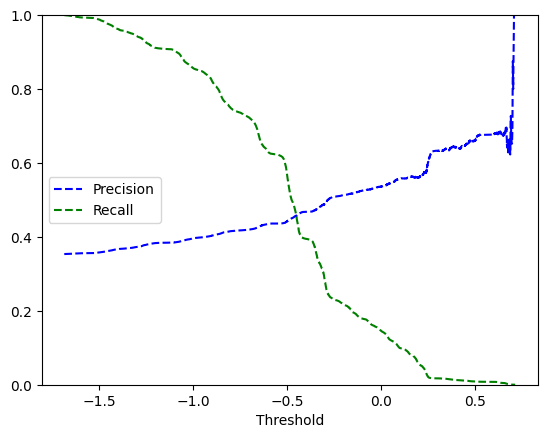

In [48]:
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score, precision_recall_curve
#decide on prediction threshold
y_scores=cross_val_predict(log_reg,x_processed,y_train,method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

def plot_precision_recall_thres(precisions, recalls, thresholds):
  plt.plot(thresholds,precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g--",label="Recall")
  plt.xlabel("Threshold")
  plt.legend(loc="center left")
  plt.ylim([0,1])

plot_precision_recall_thres(precisions,recalls, thresholds)
plt.show()

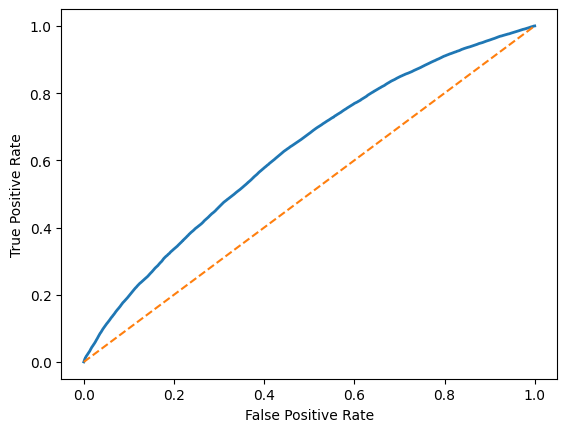


0.6252555168439291


In [53]:
#ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_train,y_scores)

def roc_plt(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], linestyle='--', label='No-skill baseline')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

roc_plt(fpr, tpr)
plt.show()

print()


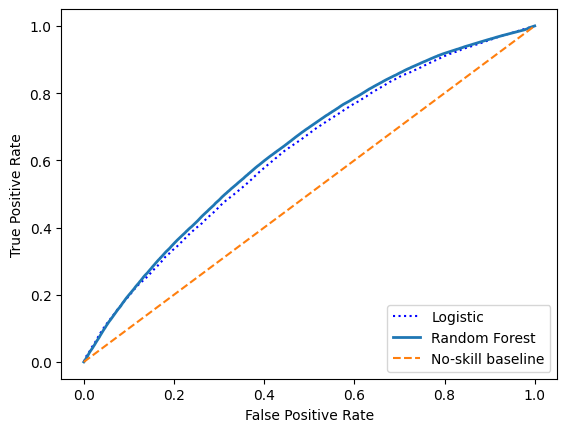

Logistic regression model: AUC=0.62526
Random Forest Classifier: AUC=0.63673


In [59]:
#Comparing model performance to a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

forest=RandomForestClassifier(random_state=42)

y_prob_forest=cross_val_predict(forest,x_processed,y_train, method="predict_proba")
y_scores_forest=y_prob_forest[:,1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train,y_scores_forest)

plt.plot(fpr,tpr, "b:",label="Logistic")
roc_plt(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()


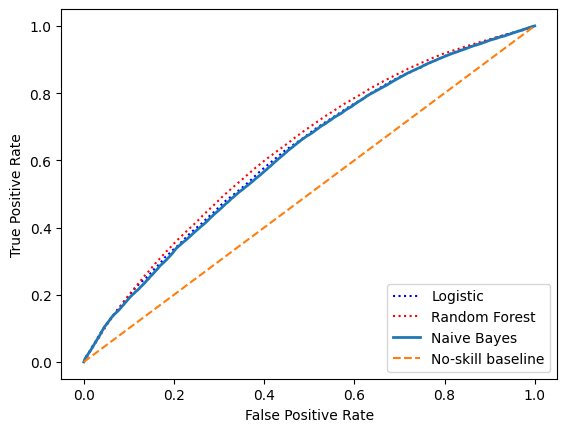

In [64]:
#Naive Bayes Classifier
from sklearn.naive_bayes import BernoulliNB

# Train NB classifier
nb = BernoulliNB()
nb.fit(x_processed, y_train)
y_scores_nb = cross_val_predict(nb, x_processed, y_train, method="predict_proba")[:, 1]

fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_train,y_scores_nb)

plt.plot(fpr,tpr, "b:",label="Logistic")
plt.plot(fpr_forest,tpr_forest, "r:",label="Random Forest")
roc_plt(fpr_nb,tpr_nb,"Naive Bayes")
plt.legend(loc="lower right")
plt.show()

In [ ]:
#AUC score across models
print("Logistic regression model: AUC=%.5f", roc_auc_score(y_train,y_scores))
print("Random Forest Classifier: AUC=%.5f", roc_auc_score(y_train,y_scores_forest))
print("Bernoulli Naive Bayes Classifier: AUC=%.5f", roc_auc_score(y_train,y_scores_nb))